In [18]:

from src.components.data_ingestion import DataIngestorFactory, DataIngestorConfig
from src.components.features_engineering import PreprocessorPipeline
from src.components.exception import CustomException
from torch.utils.data import Dataset
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys

pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")






In [19]:
factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\raw_data",
    start_train_date="2018-04-01",
    train_duration=200,
    test_duration=7,
    delay=7
)

2025-06-28 12:31:15,917 - INFO - Train: 2018-04-01 - 2018-10-18 00:00:00


KeyboardInterrupt: 

In [ ]:
train_df.shape

In [ ]:
train_df_sorted = train_df[train_df["TX_FRAUD"]==1].sort_values(["CUSTOMER_ID", "TX_DATETIME"])
train_df_sorted["TX_DATETIME_SHIFTED"] = train_df_sorted.groupby("CUSTOMER_ID")["TX_DATETIME"].shift(-1)
train_df_sorted["DATEDIFF"] = train_df_sorted["TX_DATETIME_SHIFTED"] - train_df_sorted["TX_DATETIME"]
train_df_sorted.fillna(pd.Timedelta(days=100))

In [ ]:
train_df_sorted[train_df_sorted["DATEDIFF"] <= pd.Timedelta(days=7)]

In [ ]:
result = train_df_sorted[train_df_sorted["DATEDIFF"] <= pd.Timedelta(days=7)] \
    .groupby("CUSTOMER_ID") \
    .agg({'TX_DATETIME': 'first', 'TX_DATETIME_SHIFTED': 'last'}) \
    .reset_index()
result

In [ ]:
result["FRAUD_SUM"] = 0
result["FRAUD_COUNT"] = 0

for idx, row in result.iterrows():
    CUSTOMER_id = row["CUSTOMER_ID"]
    start = row["TX_DATETIME"]
    end = row["TX_DATETIME_SHIFTED"]
    mask = (
        (train_df["CUSTOMER_ID"] == CUSTOMER_id) &
        (train_df["TX_DATETIME"] >= start) &
        (train_df["TX_DATETIME"] <= end)
    )
    filtered = train_df[mask]
    result.at[idx, "FRAUD_SUM"] = filtered["TX_FRAUD"].sum()
    result.at[idx, "FRAUD_COUNT"] = filtered["TX_FRAUD"].count()

result

In [ ]:
result["FRAUD_RATIO"] = result["FRAUD_SUM"]/ result["FRAUD_COUNT"]
result["DURATION"] = result["TX_DATETIME_SHIFTED"]- result["TX_DATETIME"]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
(result["DURATION"].dt.total_seconds() / 86400).hist(ax=axes[0])
axes[0].set_title("DURATION (days)")
axes[0].set_xlabel("Days")
result["FRAUD_RATIO"].hist(ax=axes[1])
axes[1].set_title("FRAUD_RATIO")
plt.tight_layout()
plt.show()
result["FRAUD_COUNT"].hist(ax=axes[2])
axes[1].set_title("FRAUDCOUNT")
plt.tight_layout()
plt.show()



In [ ]:
result[(result["DURATION"]<=pd.Timedelta(days=20)) & (result["FRAUD_RATIO"]>=0.3) & (result["FRAUD_COUNT"]>=10)]

In [ ]:


result[(result["DURATION"]<=pd.Timedelta(days=20)) & (result["FRAUD_RATIO"]>=0.3) & (result["FRAUD_COUNT"]>=10)].to_pickle(rf"C:\Users\thuhi\workspace\fraud_detection\data\seed\customer_seed.pkl")

In [1]:
from src.components.data_ingestion import DataIngestorFactory, DataIngestorConfig
from src.components.features_engineering import PreprocessorPipeline
from src.components.exception import CustomException
from src.components.utils import setup_logger
from torch.utils.data import Dataset
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys

pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
logger = setup_logger()
config = DataIngestorConfig()
t_seed = pd.read_pickle(rf"C:\Users\thuhi\workspace\fraud_detection\data\seed\terminal_seed.pkl")
c_seed = pd.read_pickle(rf"C:\Users\thuhi\workspace\fraud_detection\data\seed\customer_seed.pkl")

factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\raw_data",
    start_train_date="2018-04-01",
    end_train_date="2018-07-30",
    start_test_date="2018-08-01",
    end_test_date="2018-10-01"
)


2025-07-01 16:29:28,037 - INFO - Train: 2018-04-01 - 2018-07-30
2025-07-01 16:29:30,485 - INFO - Test: 2018-08-01 - 2018-10-01


In [2]:
t_seed

,TERMINAL_ID,TX_DATETIME,TX_DATETIME_SHIFTED,FRAUD_SUM,FRAUD_COUNT,FRAUD_RATIO
0,29,2018-05-19 23:36:00,2018-05-26 07:09:44,2,6,0.333333
1,31,2018-09-11 06:29:03,2018-09-12 12:38:48,2,3,0.666667
2,39,2018-06-10 22:56:04,2018-07-07 01:34:16,17,17,1.000000
3,70,2018-08-15 10:57:03,2018-09-19 19:37:45,43,50,0.860000
4,79,2018-08-04 07:02:28,2018-08-31 13:53:34,41,41,1.000000
...,...,...,...,...,...,...
661,9953,2018-04-03 07:34:14,2018-04-29 09:24:10,32,32,1.000000
663,9967,2018-06-26 00:20:32,2018-07-22 12:44:11,22,22,1.000000
664,9972,2018-07-02 05:58:14,2018-07-28 13:16:38,31,31,1.000000
665,9988,2018-04-17 08:26:28,2018-04-24 07:05:17,2,6,0.333333


In [3]:
c_seed = c_seed[(c_seed["FRAUD_COUNT"]>=6) & (c_seed["FRAUD_RATIO"]>=0.3) ]
c_seed= c_seed.reset_index(drop=True)
c_seed["TX_WINDOW"] = c_seed["TX_DATETIME_SHIFTED"] - c_seed["TX_DATETIME"]

t_seed = t_seed[(t_seed["FRAUD_COUNT"]>=10) & (t_seed["FRAUD_RATIO"]>=0.7)]
t_seed= t_seed.reset_index(drop=True)
t_seed["TX_WINDOW"] = t_seed["TX_DATETIME_SHIFTED"] - t_seed["TX_DATETIME"]

by = "CUSTOMER_ID"
c_seed["TX_SEQUENCE"] = None
logger.info("Starting customer_id")
for i in range(len(c_seed)):

    id = c_seed.loc[i,by]
    start_time = c_seed.loc[i,"TX_DATETIME"]
    end_time = c_seed.loc[i,"TX_DATETIME_SHIFTED"]
    mask = (
        (train_df[by] == id) &
        (train_df["TX_DATETIME"] >= start_time) &
        (train_df["TX_DATETIME"] <= end_time)
    )
    transactions = train_df[mask]
    sequence = transactions["TX_DATETIME"] - transactions["TX_DATETIME"].min()
    # Convert the sequence Series to a list of timedeltas (or string if you prefer)

    
    c_seed.at[i, "TX_SEQUENCE"] = sequence
by = "TERMINAL_ID"
t_seed["TX_SEQUENCE"] = None
logger.info("Starting TERMINAL_id")
for i in range(len(t_seed)):

    id = t_seed.loc[i,by]
    start_time = t_seed.loc[i,"TX_DATETIME"]
    end_time = t_seed.loc[i,"TX_DATETIME_SHIFTED"]
    mask = (
        (train_df[by] == id) &
        (train_df["TX_DATETIME"] >= start_time) &
        (train_df["TX_DATETIME"] <= end_time)
    )
    transactions = train_df[mask]
    sequence = transactions["TX_DATETIME"] - transactions["TX_DATETIME"].min()
    # Convert the sequence Series to a list of timedeltas (or string if you prefer)

    
    t_seed.at[i, "TX_SEQUENCE"] = sequence




def get_transactions(i,seed:pd.DataFrame,by,df:pd.DataFrame,date_to_insert):

    id = seed.loc[i,by]
    start_time = seed.loc[i,"TX_DATETIME"]
    end_time = seed.loc[i,"TX_DATETIME_SHIFTED"]
    mask = (
        (train_df[by] == id) &
        (train_df["TX_DATETIME"] >= start_time) &
        (train_df["TX_DATETIME"] <= end_time)
    )
    transactions = train_df[mask]
    # Apply a random normal multiplier between -30% and +70% to TX_AMOUNT
    mean = 0.2  # midpoint between -0.3 and 0.7
    std = 0.25  # arbitrary std to cover most of the range
    random_multiplier = np.clip(np.random.normal(loc=mean, scale=std, size=len(transactions)), -0.3, 0.7)
    transactions["TX_AMOUNT"] = transactions["TX_AMOUNT"] * (1 + random_multiplier)
    # Add normal random noise from -1 day to +1 day to TX_DATETIME
    # Add normal random noise from -1 day to +1 day to TX_DATETIME, grouped by 'by' column
    seconds_in_day = 86400/3
    noise_seconds = np.random.uniform(low=-seconds_in_day, high=seconds_in_day, size=len(transactions))
    noise_timedelta = pd.to_timedelta(noise_seconds, unit='s')
    sequence_deltas = seed.loc[i,"TX_SEQUENCE"]
    final_timestamps =  date_to_insert +sequence_deltas+ noise_timedelta

    transactions["TX_DATETIME"] = final_timestamps
    count = transactions["TX_FRAUD"].sum()
    return transactions,count




def get_transactions_first(i,seed:pd.DataFrame,by,df:pd.DataFrame):

    id = seed.loc[i,by]
    start_time = seed.loc[i,"TX_DATETIME"]
    end_time = seed.loc[i,"TX_DATETIME_SHIFTED"]
    mask = (
        (train_df[by] == id) &
        (train_df["TX_DATETIME"] >= start_time) &
        (train_df["TX_DATETIME"] <= end_time)
    )
    transactions = train_df[mask]
    # Apply a random normal multiplier between -30% and +70% to TX_AMOUNT
    mean = 0.2  # midpoint between -0.3 and 0.7
    std = 0.25  # arbitrary std to cover most of the range
    random_multiplier = np.clip(np.random.normal(loc=mean, scale=std, size=len(transactions)), -0.3, 0.7)
    transactions["TX_AMOUNT"] = transactions["TX_AMOUNT"] * (1 + random_multiplier)
    # Add normal random noise from -1 day to +1 day to TX_DATETIME
    # Add normal random noise from -1 day to +1 day to TX_DATETIME, grouped by 'by' column
    seconds_in_day = 86400/3
    noise_seconds = np.random.uniform(low=-seconds_in_day, high=seconds_in_day, size=len(transactions))
    noise_timedelta = pd.to_timedelta(noise_seconds, unit='s')

    first = df[df[by]==id]["TX_DATETIME"].min()

    sequence_deltas = seed.loc[i,"TX_SEQUENCE"]
    sequence_length = seed.loc[i,"TX_WINDOW"]
    try:
        final_timestamps =  first +sequence_deltas+ noise_timedelta- sequence_length
    except Exception as e:
        logger.info(first)
        logger.info(sequence_deltas)
        logger.info(noise_timedelta)
    transactions["TX_DATETIME"] = final_timestamps
    count = transactions["TX_FRAUD"].sum()
    return transactions,count
os.chdir("C:/Users/thuhi/workspace/fraud_detection")
print("Current working directory:", os.getcwd())


2025-07-01 16:29:43,869 - INFO - Starting customer_id
2025-07-01 16:29:57,033 - INFO - Starting TERMINAL_id
Current working directory: C:\Users\thuhi\workspace\fraud_detection


In [27]:
train_df =  final_dataset[(final_dataset["TX_DATETIME"]<= pd.to_datetime("2019-01-01"))]

In [29]:
import pandas as pd
import numpy as np

def mark_insertion_points(
    df: pd.DataFrame,
    by: str,
    length: int,
    tolerance: int
) -> pd.DataFrame:
    """
    Finds and marks well-spaced, safe insertion points in a new 'INSERT' column.
    (Corrected Version)

    Args:
        df: The input DataFrame.
        by: The column to group by (e.g., 'TERMINAL_ID').
        length: The number of transactions to look at forward and backward.
        tolerance: The max number of frauds allowed in the window.

    Returns:
        A new DataFrame with an 'INSERT' column (0 or 1), preserving original order.
    """
    if 'TX_FRAUD' not in df.columns or by not in df.columns:
        raise ValueError("DataFrame must contain 'TX_FRAUD' and the 'by' column.")

    # Preserve original order by saving the index
    df_sorted = df.sort_values(by=[by, 'TX_DATETIME']).reset_index()

    final_indices = []
    
    for group_name, group_df in df_sorted.groupby(by):
        if len(group_df) < (2 * length + 1):
            continue

        # --- Phase 1: Scoring (Unchanged) ---
        window_size = 2 * length + 1
        safety_score = group_df['TX_FRAUD'].rolling(window=window_size, center=True, min_periods=1).sum()
        is_candidate = safety_score < tolerance

        # --- Phase 2: Clustering & Selecting Middle (Corrected Logic) ---
        # If there are no candidates in this group, skip to the next.
# --- Phase 2: Clustering & Selecting Middle (Modified Logic for Max Block Size) ---
# If there are no candidates in this group, skip to the next.
        if not is_candidate.any():
            continue

        # 1. Create block IDs with a maximum block size for True (candidate) blocks
        max_block_size = window_size * 2 + 1

        # Initialize block_ids with the same index as is_candidate
        block_ids = pd.Series(0, index=is_candidate.index)

        # Track current block ID and count of consecutive True values
        current_block = 0
        true_count = 0

        for idx in is_candidate.index:
            if is_candidate[idx]:  # Current value is True (candidate)
                if true_count >= max_block_size:
                    # Start a new block if max_block_size is reached
                    current_block += 1
                    true_count = 1  # Reset count for the new block
                else:
                    true_count += 1  # Increment count within the same block
            else:  # Current value is False (non-candidate)
                current_block += 1  # Start a new block for False
                true_count = 0  # Reset True count
            block_ids[idx] = current_block

        # 2. Filter the block_ids series to only include the candidates
        candidate_blocks = block_ids[is_candidate]

        # 3. Group these candidates by their block_id and find the middle index for each block
        middle_point_indices = candidate_blocks.groupby(candidate_blocks).apply(
            lambda block: block.index[len(block) // 2]
        ).tolist()


        # --- Phase 3: Filtering with Cooldown (Unchanged) ---
        if not middle_point_indices:
            continue

        cooldown_period = 1
        middle_point_indices.sort()
        
        last_selected_index = -np.inf
        group_final_indices = []

        for idx in middle_point_indices:
            if idx >= last_selected_index + cooldown_period:
                group_final_indices.append(idx)
                last_selected_index = idx
        
        final_indices.extend(group_final_indices)

    # --- Finalization (Unchanged) ---
    df_sorted['INSERT'] = 0
    if final_indices:
        df_sorted.loc[final_indices, 'INSERT'] = 1

    df_result = df_sorted.sort_values('index').set_index('index')
    df_result.index.name = None
    
    return df_result
WINDOW_LENGTH = 7
FRAUD_TOLERANCE = 1
COOLDOWN_PERIOD = 2* WINDOW_LENGTH

print("--- Marking Insertion Points ---")
print(f"Window length: {WINDOW_LENGTH}, Cooldown period: {COOLDOWN_PERIOD} transactions, Tolerance: {FRAUD_TOLERANCE} fraud txs")

# Get the new dataframe with the 'INSERT' column
df_with_inserts = mark_insertion_points(
    train_df,
    by='CUSTOMER_ID',
    length=WINDOW_LENGTH,
    tolerance=FRAUD_TOLERANCE
)
ids = []
for i in range(len(c_seed)):
    id = c_seed.loc[i,"CUSTOMER_ID"]
    ids.append(id)
df_with_inserts[df_with_inserts["CUSTOMER_ID"].astype(int).isin(ids)].groupby("CUSTOMER_ID")["INSERT"].sum().mean()

--- Marking Insertion Points ---
Window length: 7, Cooldown period: 14 transactions, Tolerance: 1 fraud txs


2.8095238095238093

In [36]:
# Compare final_dataset with df_with_inserts (excluding the 'INSERT' column)
df_base = df_with_inserts.drop(columns=['INSERT'])



--- RUNNING THE INJECTION PROCESS ---
Preparing data...
Phase 1: Finding all potential jobs with ID swapping...
Found 12228 total potential jobs.
Phase 2: Applying budget of 20000 seeds...
Selected 12228 jobs to execute.
Phase 3 & 4: Processing 4972 entities and finalizing...


Applying transformations: 100%|██████████| 4972/4972 [12:11<00:00,  6.80it/s]


Budgeted transformation with ID swapping complete.

--- AFTER TRANSFORMATION ---
0.44979762494699954


<Axes: >

<Axes: >

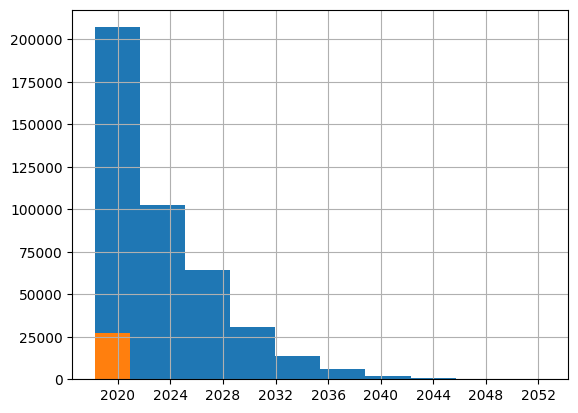

In [48]:


# --- MODIFIED get_transactions FUNCTION ---
# It now takes a `target_id` to assign to the new fraudulent transactions.

def get_transactions(i, seed: pd.DataFrame, by: str, original_df: pd.DataFrame, date_to_insert, target_id):
    """
    Finds a sequence of real transactions based on a recipe, transforms them,
    and assigns them to a new target entity.
    """
    # Find ingredients based on the RECIPE's ID
    recipe_id = seed.loc[i, by]
    start_time = seed.loc[i, "TX_DATETIME"]
    end_time = seed.loc[i, "TX_DATETIME_SHIFTED"]
    
    mask = (
        (original_df[by] == recipe_id) &
        (original_df["TX_DATETIME"] >= start_time) &
        (original_df["TX_DATETIME"] <= end_time)
    )
    transactions = original_df[mask].copy()

    if transactions.empty:
        return pd.DataFrame(), 0
    
    # --- Modifications (Amount, Timestamp, Fraud Flag) ---
    mean, std = 0.2, 0.25
    random_multiplier = np.clip(np.random.normal(loc=mean, scale=std, size=len(transactions)), -0.3, 0.7)
    transactions["TX_AMOUNT"] *= (1 + random_multiplier)

    seconds_in_day = 86400 / 3
    noise_seconds = np.random.uniform(low=-seconds_in_day, high=seconds_in_day, size=len(transactions))
    noise_timedelta = pd.to_timedelta(noise_seconds, unit='s')
    
    sequence_deltas = seed.loc[i, "TX_SEQUENCE"]
    if len(sequence_deltas) != len(transactions):
        # Handle mismatch gracefully
        if len(sequence_deltas) > len(transactions):
            sequence_deltas = sequence_deltas.iloc[:len(transactions)]
        else: # sequence is shorter, cannot proceed
             return pd.DataFrame(), 0
            
    transactions = transactions.reset_index()
    sequence_deltas = sequence_deltas.reset_index(drop=True)
    noise_timedelta = pd.Series(noise_timedelta).reset_index(drop=True)

    final_timestamps = date_to_insert + sequence_deltas + noise_timedelta
    transactions["TX_DATETIME"] = final_timestamps
    
    transactions["TX_FRAUD"] = 1
    
    # --- NEW, CRITICAL STEP FOR ID SWAPPING ---
    transactions[by] = target_id
    
    return transactions.set_index('index'), 0 # Count is not needed here


import random
from tqdm import tqdm

# Your get_transactions function remains the same and is correct.

def transform_and_inject_with_swapping(
    main_df_with_inserts: pd.DataFrame,
    seed_recipe_df: pd.DataFrame,
    by_column: str,
    seed_budget: int,
    allow_id_swapping: bool = True
) -> pd.DataFrame:
    """
    (Corrected Version)
    Transforms real transactions and injects them group-wise, controlled by a budget,
    with an option to "transplant" fraud patterns to new entities.
    """
    print("Preparing data...")
    main_df = main_df_with_inserts.copy()
    main_df['TX_DATETIME'] = pd.to_datetime(main_df['TX_DATETIME'])
    seed_recipe_df['TX_DATETIME'] = pd.to_datetime(seed_recipe_df['TX_DATETIME'])
    seed_recipe_df['TX_DATETIME_SHIFTED'] = pd.to_datetime(seed_recipe_df['TX_DATETIME_SHIFTED'])

    # --- Phase 1: Create All Potential Jobs (Unchanged) ---
    print("Phase 1: Finding all potential jobs with ID swapping...")
    insertion_slots = main_df[main_df['INSERT'] == 1]
    entities_with_recipes = set(seed_recipe_df[by_column].unique())
    all_recipe_indices = seed_recipe_df.index.tolist()
    all_potential_jobs = []
    for slot_index, slot in insertion_slots.iterrows():
        target_entity_id = slot[by_column]
        if target_entity_id in entities_with_recipes:
            entity_recipes = seed_recipe_df[seed_recipe_df[by_column] == target_entity_id]
            if not entity_recipes.empty:
                recipe_index = entity_recipes.index[0]
                all_potential_jobs.append({'slot_index': slot_index, 'recipe_index': recipe_index})
        elif allow_id_swapping:
            if all_recipe_indices:
                recipe_index = random.choice(all_recipe_indices)
                all_potential_jobs.append({'slot_index': slot_index, 'recipe_index': recipe_index})
    
    print(f"Found {len(all_potential_jobs)} total potential jobs.")

    # --- Phase 2: Apply the Budget (Unchanged) ---
    print(f"Phase 2: Applying budget of {seed_budget} seeds...")
    random.shuffle(all_potential_jobs)
    approved_jobs = all_potential_jobs[:seed_budget]
    if not approved_jobs: return main_df.drop(columns=['INSERT'])
    for job in approved_jobs:
        job['target_id'] = main_df.loc[job['slot_index'], by_column]
        job['insertion_time'] = main_df.loc[job['slot_index'], 'TX_DATETIME']
        recipe = seed_recipe_df.loc[job['recipe_index']]
        job['duration'] = recipe['TX_DATETIME_SHIFTED'] - recipe['TX_DATETIME']
    
    print(f"Selected {len(approved_jobs)} jobs to execute.")
    approved_jobs_df = pd.DataFrame(approved_jobs)
    jobs_for_entity = {entity: group for entity, group in approved_jobs_df.groupby('target_id')}

    # --- Phase 3: Group and Process ---
    def process_group(group_df: pd.DataFrame) -> pd.DataFrame:
        target_id = group_df.name
        if target_id not in jobs_for_entity:
            return group_df

        local_jobs_df = jobs_for_entity[target_id]
        shift_schedule = local_jobs_df.sort_values('insertion_time').reset_index(drop=True)
        shift_schedule['cumulative_shift'] = shift_schedule['duration'].cumsum().shift(1).fillna(pd.Timedelta(0))

        # --- THE FIX IS HERE ---
        # Sort the group and reset the index to a simple 0, 1, 2... RangeIndex
        df_sorted = group_df.sort_values('TX_DATETIME').reset_index(drop=True)
        
        merged = pd.merge_asof(
            df_sorted,
            shift_schedule[['insertion_time', 'duration']].rename(columns={'insertion_time': 'TX_DATETIME'}),
            on='TX_DATETIME', direction='backward'
        )
        # --- END OF FIX ---
        
        merged['shift_to_apply'] = merged['duration'].cumsum().shift(1).fillna(pd.Timedelta(0))
        shifted_group = df_sorted.copy()
        shifted_group['TX_DATETIME'] = merged['TX_DATETIME'] + merged['shift_to_apply']
        
        indices_to_drop = set()
        transformed_seeds = []
        for _, job in shift_schedule.iterrows():
            actual_insert_date = job['insertion_time'] + job['cumulative_shift']
            
            # The original_df passed to get_transactions must have its original index
            # This is why we use `main_df` here, which is the full, unmodified DF
            transactions, _ = get_transactions(
                i=job['recipe_index'], seed=seed_recipe_df, by=by_column,
                original_df=main_df, 
                date_to_insert=actual_insert_date,
                target_id=target_id
            )
            
            if not transactions.empty:
                transformed_seeds.append(transactions)
                # The index from `get_transactions` is the original index from `main_df`
                indices_to_drop.update(transactions.index)

        # Drop from the globally-indexed `shifted_group` before it was reset
        final_group_main = group_df.drop(index=list(indices_to_drop), errors='ignore')

        # Re-apply the shift logic to the now-smaller group
        if not final_group_main.empty:
            df_sorted_after_drop = final_group_main.sort_values('TX_DATETIME').reset_index(drop=True)
            merged_after_drop = pd.merge_asof(df_sorted_after_drop, shift_schedule[['insertion_time', 'duration']].rename(columns={'insertion_time': 'TX_DATETIME'}), on='TX_DATETIME', direction='backward')
            merged_after_drop['shift_to_apply'] = merged_after_drop['duration'].cumsum().shift(1).fillna(pd.Timedelta(0))
            final_group_main = df_sorted_after_drop.copy()
            final_group_main['TX_DATETIME'] = merged_after_drop['TX_DATETIME'] + merged_after_drop['shift_to_apply']
        
        final_group = pd.concat([final_group_main] + transformed_seeds, ignore_index=True)
        return final_group

    # --- Main Execution ---
    print(f"Phase 3 & 4: Processing {main_df[by_column].nunique()} entities and finalizing...")
    tqdm.pandas(desc=f"Applying transformations")
    processed_groups = main_df.groupby(by_column).progress_apply(process_group)

    final_df = processed_groups.reset_index(drop=True)
    final_df = final_df.sort_values(by='TX_DATETIME').reset_index(drop=True)
    if 'INSERT' in final_df.columns:
        final_df = final_df.drop(columns=['INSERT'])

    print("Budgeted transformation with ID swapping complete.")
    return final_df

SEED_BUDGET = 20000
ALLOW_SWAPPING = True


print("\n--- RUNNING THE INJECTION PROCESS ---")

final_dataset = transform_and_inject_with_swapping(
    main_df_with_inserts=df_with_inserts,
    seed_recipe_df=c_seed,
    by_column='CUSTOMER_ID',
    seed_budget=SEED_BUDGET,
    allow_id_swapping=ALLOW_SWAPPING
)

print("\n--- AFTER TRANSFORMATION ---")
print(final_dataset["TX_FRAUD"].mean())

display( final_dataset[final_dataset["TX_FRAUD"]==1]["TX_DATETIME"].hist())
display( final_dataset[final_dataset["TX_FRAUD_SCENARIO"]==3]["TX_DATETIME"].hist())

<Axes: >

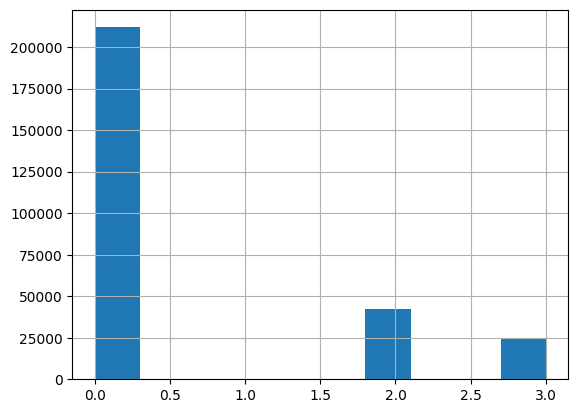

In [57]:
seeded_df = final_dataset[ (final_dataset["TX_DATETIME"] < pd.to_datetime("2019-01-01"))]
seeded_df["TX_FRAUD_SCENARIO"].hist()

In [58]:
# Ensure the output directory exists
seeded_df = final_dataset[ (final_dataset["TX_DATETIME"] < pd.to_datetime("2019-01-01"))]

output_dir = "data/upsampled_data_both"
os.makedirs(output_dir, exist_ok=True)

# Group by date and save each group as a pickle file
for date, group in seeded_df.groupby(seeded_df["TX_DATETIME"].dt.date):
    filename = os.path.join(output_dir, f"{date}.pkl")
    group.to_pickle(filename)

In [59]:
factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\upsampled_data_both",
    start_train_date="2018-04-01",
    train_duration="all",
    test_duration=7,
    delay=7
)
from src.components.features_engineering import PreprocessorPipeline

transformed = PreprocessorPipeline(train_df,add_method=["weekend", "night", "customer_char", "terminal_char"]).process()
output_dir = "data/transformed_upsampled_data_both"
os.makedirs(output_dir, exist_ok=True)

# Group by date and save each group as a pickle file
for date, group in transformed.groupby(transformed["TX_DATETIME"].dt.date):
    filename = os.path.join(output_dir, f"{date}.pkl")
    group.to_pickle(filename)

2025-06-30 20:48:38,320 - INFO - train_duration is all
2025-06-30 20:48:38,322 - INFO - test_duration is 7
2025-06-30 20:48:38,324 - INFO - Train: 2018-04-01 - None
2025-06-30 20:48:40,477 - INFO - Test: None - None
2025-06-30 20:48:40,478 - WARNING - test_df is empty or None


In [60]:
transformed["TX_FRAUD"].mean()

0.41187723678884